In [2]:
%load_ext autoreload
%autoreload 2

import os
import re
import math
import glob
from importlib import reload

import tqdm 
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

In [3]:
obj_dataset = dataset.replay_mapping_from_cache(1000)

Loading objects from .data/: 100%|██████████| 1000/1000 [00:24<00:00, 41.47it/s]


In [4]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
840,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
841,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
842,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
843,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [5]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

Turning beatmaps into time series data: 100%|██████████| 845/845 [06:40<00:00,  2.11it/s]
E:\Projects\osu\osu\dataset.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  tensor_list = [torch.tensor(seq, dtype=torch.float) for seq in data]
Turning replays into time series data: 100%|██████████| 845/845 [00:27<00:00, 30.89it/s]


In [6]:
input = input_data
output = output_data

In [7]:
output[0:500]

x         y   k1   k2
chunk frame                              
0     0     -0.220486 -0.116898  0.0  0.0
      1     -0.220486 -0.116898  0.0  0.0
      2     -0.229167 -0.108796  0.0  0.0
      3     -0.229167 -0.108796  0.0  0.0
      4     -0.227430 -0.107639  0.0  0.0
...               ...       ...  ...  ...
      495    0.107639  0.005787  0.0  1.0
      496    0.165799  0.015046  0.0  1.0
      497    0.174479  0.024305  0.0  1.0
      498    0.187500  0.041667  0.0  1.0
      499    0.187500  0.040509  0.0  1.0

[500 rows x 4 columns]

In [8]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

(3239, 2048, 5)

In [8]:
xs

array([[[-0.35546875, -0.5       ,  1.        ,  1.        ,
          0.        ],
        [-0.35546875, -0.5       ,  0.94666666,  1.        ,
          0.        ],
        [-0.35546875, -0.5       ,  0.8933333 ,  1.        ,
          0.        ],
        ...,
        [-0.41601562, -0.03125   ,  0.12888889,  1.        ,
          0.        ],
        [-0.41601562, -0.03125   ,  0.07555556,  1.        ,
          0.        ],
        [-0.41601562, -0.03125   ,  0.02222222,  1.        ,
          0.        ]],

       [[-0.42578125, -0.0546875 ,  0.        ,  1.        ,
          0.        ],
        [-0.4375    , -0.09375   ,  0.        ,  1.        ,
          0.        ],
        [-0.44140625, -0.13802083,  0.        ,  1.        ,
          0.        ],
        ...,
        [ 0.328125  ,  0.3828125 ,  0.19333333,  1.        ,
          0.        ],
        [ 0.328125  ,  0.3828125 ,  0.14      ,  1.        ,
          0.        ],
        [ 0.328125  ,  0.3828125 ,  0.08666667, 

In [9]:
# ys = ys[0:xs.shape[0]]

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 
# x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))
# 
# train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
# 
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
from osu.gan import OsuReplayGAN
from osu.rnn import OsuReplayRNN

In [12]:
print("Creating RNN model...")
rnn = OsuReplayRNN(noise_std=0.05)
rnn.load_data(xs, ys)

Creating RNN model...
RNN Model initialized on cuda (noise_std=0.05)
Model parameters: 23444
[[[-0.20507812  0.38541666  1.          1.          0.        ]
  [-0.20507812  0.38541666  0.94666666  1.          0.        ]
  [-0.20507812  0.38541666  0.8933333   1.          0.        ]
  ...
  [-0.20898438 -0.35677084  0.02444444  0.          0.        ]
  [-0.296875   -0.15885417  0.30444443  0.          0.        ]
  [-0.296875   -0.15885417  0.25111112  0.          0.        ]]

 [[ 0.296875    0.0078125   0.3         0.          0.        ]
  [ 0.296875    0.0078125   0.24666667  0.          0.        ]
  [ 0.296875    0.0078125   0.19333333  0.          0.        ]
  ...
  [-0.11914062 -0.33854166  0.28444445  0.          0.        ]
  [-0.11914062 -0.33854166  0.23111111  0.          0.        ]
  [-0.11914062 -0.33854166  0.17777778  0.          0.        ]]

 [[ 0.34960938  0.40364584  0.18888889  0.          0.        ]
  [ 0.34960938  0.40364584  0.13555555  0.          0.     

Epoch 1/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 66.83it/s]


Epoch 1/50, Train Loss: 0.0686, Test Loss: 0.0604


Epoch 2/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.32it/s]


Epoch 2/50, Train Loss: 0.0569, Test Loss: 0.0526


Epoch 3/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 88.17it/s]


Epoch 3/50, Train Loss: 0.0530, Test Loss: 0.0518


Epoch 4/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.86it/s]


Epoch 4/50, Train Loss: 0.0523, Test Loss: 0.0513


Epoch 5/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 88.36it/s]


Epoch 5/50, Train Loss: 0.0514, Test Loss: 0.0497


Epoch 6/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.13it/s]


Epoch 6/50, Train Loss: 0.0490, Test Loss: 0.0470


Epoch 7/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 87.27it/s]


Epoch 7/50, Train Loss: 0.0475, Test Loss: 0.0459


Epoch 8/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.41it/s]


Epoch 8/50, Train Loss: 0.0470, Test Loss: 0.0460


Epoch 9/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 82.16it/s]


Epoch 9/50, Train Loss: 0.0467, Test Loss: 0.0453


Epoch 10/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 83.84it/s]


Epoch 10/50, Train Loss: 0.0463, Test Loss: 0.0453


Epoch 11/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.68it/s]


Epoch 11/50, Train Loss: 0.0460, Test Loss: 0.0450


Epoch 12/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.06it/s]


Epoch 12/50, Train Loss: 0.0459, Test Loss: 0.0448


Epoch 13/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.95it/s]


Epoch 13/50, Train Loss: 0.0457, Test Loss: 0.0447


Epoch 14/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.19it/s]


Epoch 14/50, Train Loss: 0.0456, Test Loss: 0.0446


Epoch 15/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.95it/s]


Epoch 15/50, Train Loss: 0.0455, Test Loss: 0.0445


Epoch 16/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.86it/s]


Epoch 16/50, Train Loss: 0.0453, Test Loss: 0.0442


Epoch 17/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.06it/s]


Epoch 17/50, Train Loss: 0.0452, Test Loss: 0.0444


Epoch 18/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.32it/s]


Epoch 18/50, Train Loss: 0.0451, Test Loss: 0.0441


Epoch 19/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.10it/s]


Epoch 19/50, Train Loss: 0.0449, Test Loss: 0.0439


Epoch 20/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.68it/s]


Epoch 20/50, Train Loss: 0.0449, Test Loss: 0.0439


Epoch 21/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.70it/s]


Epoch 21/50, Train Loss: 0.0447, Test Loss: 0.0437


Epoch 22/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.68it/s]


Epoch 22/50, Train Loss: 0.0445, Test Loss: 0.0436


Epoch 23/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 83.33it/s]


Epoch 23/50, Train Loss: 0.0446, Test Loss: 0.0437


Epoch 24/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.86it/s]


Epoch 24/50, Train Loss: 0.0445, Test Loss: 0.0439


Epoch 25/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.68it/s]


Epoch 25/50, Train Loss: 0.0444, Test Loss: 0.0436


Epoch 26/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.32it/s]


Epoch 26/50, Train Loss: 0.0443, Test Loss: 0.0434


Epoch 27/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.53it/s]


Epoch 27/50, Train Loss: 0.0442, Test Loss: 0.0435


Epoch 28/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 69.54it/s]


Epoch 28/50, Train Loss: 0.0441, Test Loss: 0.0433


Epoch 29/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.33it/s]


Epoch 29/50, Train Loss: 0.0441, Test Loss: 0.0435


Epoch 30/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 82.24it/s]


Epoch 30/50, Train Loss: 0.0441, Test Loss: 0.0431


Epoch 31/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 82.33it/s]


Epoch 31/50, Train Loss: 0.0440, Test Loss: 0.0433


Epoch 32/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 77.72it/s]


Epoch 32/50, Train Loss: 0.0440, Test Loss: 0.0431


Epoch 33/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 77.28it/s]


Epoch 33/50, Train Loss: 0.0438, Test Loss: 0.0430


Epoch 34/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 81.84it/s]


Epoch 34/50, Train Loss: 0.0439, Test Loss: 0.0429


Epoch 35/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.71it/s]


Epoch 35/50, Train Loss: 0.0438, Test Loss: 0.0434


Epoch 36/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.22it/s]


Epoch 36/50, Train Loss: 0.0438, Test Loss: 0.0428


Epoch 37/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 82.49it/s]


Epoch 37/50, Train Loss: 0.0437, Test Loss: 0.0428


Epoch 38/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.22it/s]


Epoch 38/50, Train Loss: 0.0437, Test Loss: 0.0430


Epoch 39/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.19it/s]


Epoch 39/50, Train Loss: 0.0436, Test Loss: 0.0427


Epoch 40/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.86it/s]


Epoch 40/50, Train Loss: 0.0436, Test Loss: 0.0430


Epoch 41/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.24it/s]


Epoch 41/50, Train Loss: 0.0435, Test Loss: 0.0427


Epoch 42/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.50it/s]


Epoch 42/50, Train Loss: 0.0435, Test Loss: 0.0426


Epoch 43/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.13it/s]


Epoch 43/50, Train Loss: 0.0435, Test Loss: 0.0428


Epoch 44/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.22it/s]


Epoch 44/50, Train Loss: 0.0434, Test Loss: 0.0425


Epoch 45/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.02it/s]


Epoch 45/50, Train Loss: 0.0434, Test Loss: 0.0427


Epoch 46/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 86.50it/s]


Epoch 46/50, Train Loss: 0.0435, Test Loss: 0.0430


Epoch 47/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.75it/s]


Epoch 47/50, Train Loss: 0.0434, Test Loss: 0.0427


Epoch 48/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 85.95it/s]


Epoch 48/50, Train Loss: 0.0434, Test Loss: 0.0426


Epoch 49/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.29it/s]


Epoch 49/50, Train Loss: 0.0433, Test Loss: 0.0427


Epoch 50/50 (Train): 100%|██████████| 41/41 [00:00<00:00, 84.54it/s]


Epoch 50/50, Train Loss: 0.0433, Test Loss: 0.0426


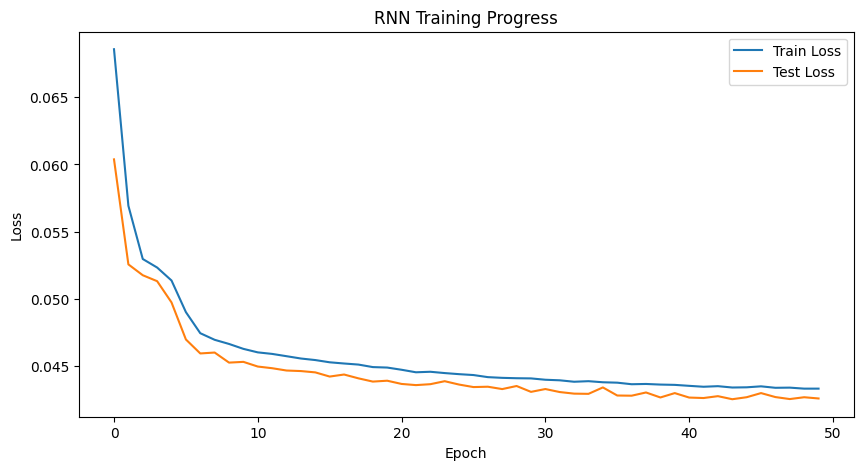

RNN model saved to .trained/rnn_2025-07-15_03-19-15.pt


In [13]:
RNN_EPOCHS = 50

# Train the RNN
rnn.train(epochs=RNN_EPOCHS)
rnn.plot_losses()
rnn.save()

In [ ]:
print("Creating GAN model...")
gan = OsuReplayGAN(batch_size=BATCH_SIZE, noise_dim=4)
gan.load_data(xs, ys)

Epoch 1/15 (GAN): 100%|██████████| 204/204 [01:16<00:00,  2.67it/s]


Epoch 1/15, Gen Loss: 0.9338, Disc Loss: 0.6959


Epoch 2/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.04it/s]


Epoch 2/15, Gen Loss: 0.7997, Disc Loss: 0.6939


Epoch 3/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.04it/s]


Epoch 3/15, Gen Loss: 0.7855, Disc Loss: 0.6937


Epoch 4/15 (GAN): 100%|██████████| 204/204 [01:06<00:00,  3.05it/s]


Epoch 4/15, Gen Loss: 0.7783, Disc Loss: 0.6935


Epoch 5/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.02it/s]


Epoch 5/15, Gen Loss: 0.7718, Disc Loss: 0.6936


Epoch 6/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.03it/s]


Epoch 6/15, Gen Loss: 0.7733, Disc Loss: 0.6930


Epoch 7/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.02it/s]


Epoch 7/15, Gen Loss: 0.7726, Disc Loss: 0.6929


Epoch 8/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.02it/s]


Epoch 8/15, Gen Loss: 0.7714, Disc Loss: 0.6932


Epoch 9/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.03it/s]


Epoch 9/15, Gen Loss: 0.7708, Disc Loss: 0.6929


Epoch 10/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.02it/s]


Epoch 10/15, Gen Loss: 0.7689, Disc Loss: 0.6933


Epoch 11/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.02it/s]


Epoch 11/15, Gen Loss: 0.7677, Disc Loss: 0.6930


Epoch 12/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.02it/s]


Epoch 12/15, Gen Loss: 0.7689, Disc Loss: 0.6931


Epoch 13/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.03it/s]


Epoch 13/15, Gen Loss: 0.7654, Disc Loss: 0.6932


Epoch 14/15 (GAN): 100%|██████████| 204/204 [01:06<00:00,  3.06it/s]


Epoch 14/15, Gen Loss: 0.7710, Disc Loss: 0.6930


Epoch 15/15 (GAN): 100%|██████████| 204/204 [01:07<00:00,  3.04it/s]


Epoch 15/15, Gen Loss: 0.7515, Disc Loss: 0.6932


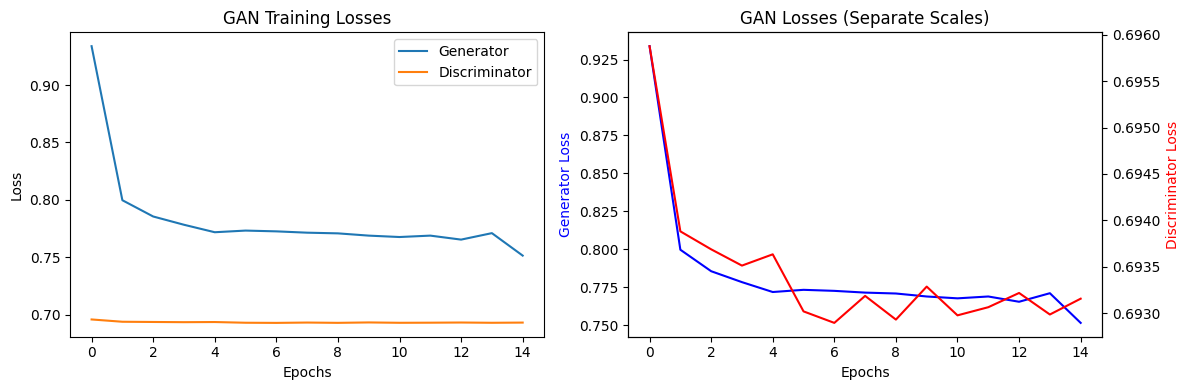

GAN models saved with prefix .trained/gan_2025-07-13_21-07-19


In [14]:
GAN_EPOCHS = 15

# Train the GAN
gan.train(epochs=GAN_EPOCHS, lambda_recon=10.0)
gan.plot_losses()
gan.save()

In [18]:
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'zuttosummer'
test_mods = Mods.HARD_ROCK
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

Turning beatmaps into time series data: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


In [19]:
with torch.no_grad():
    # Use generator for inference
    replay_data = rnn.generate(data)
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

print(f"Generated replay data shape: {replay_data.shape}")
print(f"Saved to .generated\\{test_name}.npy")

Generated replay data shape: (12288, 4)
Saved to .generated\zuttosummer.npy


In [22]:
replay_data[:500]

array([[-7.6401226e-02,  1.6060598e-02,  1.9155759e-01,  2.2359020e-01],
       [-1.0287747e-01,  5.0069392e-04,  2.8299251e-01,  2.9400536e-01],
       [-1.1234121e-01, -6.4345449e-03,  2.7708298e-01,  2.7145952e-01],
       ...,
       [ 3.4575951e-01, -2.0824677e-01,  5.1782459e-01,  5.1854724e-01],
       [ 3.6372358e-01, -5.6568198e-02,  4.1319931e-01,  4.3332133e-01],
       [ 4.0952444e-01,  5.2603938e-02,  3.3167818e-01,  3.6291781e-01]],
      shape=(500, 4), dtype=float32)

In [1]:
import importlib
import osu.preview.preview as preview

importlib.reload(preview)

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)

E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
osu! path: C:\Users\niooi\AppData\Roaming/../Local/osu!


NameError: name 'replay_data' is not defined